<a href="https://colab.research.google.com/github/aryan2619/E2E-Vendor-Performance-Data-Analytics/blob/main/Vendor_Dashboard_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Unziping DataSet**


In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/purchases.csv      
  inflating: __MACOSX/data/._purchases.csv  
  inflating: data/purchase_prices.csv  
  inflating: __MACOSX/data/._purchase_prices.csv  
  inflating: data/vendor_invoice.csv  
  inflating: __MACOSX/data/._vendor_invoice.csv  
  inflating: data/begin_inventory.csv  
  inflating: __MACOSX/data/._begin_inventory.csv  
   creating: data/.ipynb_checkpoints/
  inflating: data/end_inventory.csv  
  inflating: __MACOSX/data/._end_inventory.csv  
  inflating: data/sales.csv          
  inflating: __MACOSX/data/._sales.csv  
  inflating: data/.ipynb_checkpoints/begin_inventory-checkpoint.csv  
  inflating: __MACOSX/data/.ipynb_checkpoints/._begin_inventory-checkpoint.csv  


You can extract the contents of a zip file using the `unzip` command in a code cell.

**Importing Libraries**

In [ ]:
import pandas as pd
import os
from sqlalchemy import create_engine
import logging
import time

# ✅ Ensure logs folder exists
log_dir = os.path.join(os.getcwd(), 'logs')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

log_file = os.path.join(log_dir, 'ingestion_db.log')

# ✅ Configure logging robustly
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Remove existing handlers if any (important for Jupyter/Colab)
for handler in logger.handlers[:]:
    logger.removeHandler(handler)

file_handler = logging.FileHandler(log_file)
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

logger.info("Logging setup complete. Starting script.")

# ✅ Create SQLite Engine
engine = create_engine('sqlite:///inventory.db')
logger.info("Database engine created.")

# ✅ Chunked ingestion function with memory optimization
def ingest_db_chunked(file_path, table_name, engine, chunksize=50000):
    logger.info(f"Starting ingestion for {table_name}")
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        logger.info(f"Ingesting chunk of size {chunk.shape}")
        # Optimize memory by converting object columns to category where possible
        for col in chunk.select_dtypes(include='object').columns:
            chunk[col] = chunk[col].astype('category')
        chunk.to_sql(table_name, engine, if_exists='append', index=False)
    logger.info(f"Completed ingestion for {table_name}")

# ✅ Main ingestion runner
def load_raw_data():
    start = time.time()
    data_dir = 'data'

    if not os.path.exists(data_dir):
        logger.error(f"Data folder '{data_dir}' not found.")
        return

    files = [file for file in os.listdir(data_dir) if file.endswith('.csv')]
    if not files:
        logger.warning("No CSV files found in data folder.")
        return

    for file in files:
        file_path = os.path.join(data_dir, file)
        table_name = file[:-4]
        print("Ingesting:", file)
        logger.info(f"Processing file: {file}")
        ingest_db_chunked(file_path, table_name, engine)
        print(file, "Ingested Successfully\n")

    end = time.time()
    total_time = (end - start) / 60
    logger.info('All files ingestion completed.')
    logger.info(f'Total Time Taken: {total_time:.2f} minutes')

# ✅ Entry point
if __name__ == '__main__':
    load_raw_data()


Ingesting: sales.csv
sales.csv Ingested Successfully

Ingesting: end_inventory.csv
end_inventory.csv Ingested Successfully

Ingesting: vendor_invoice.csv
vendor_invoice.csv Ingested Successfully

Ingesting: begin_inventory.csv
begin_inventory.csv Ingested Successfully

Ingesting: purchases.csv
purchases.csv Ingested Successfully

Ingesting: purchase_prices.csv
purchase_prices.csv Ingested Successfully



**Exploratory Data Analysis**
Understanding the dataset to explore how the data is present in the databse and if there is a need of creating some aggregated tables that can help with:
**-> Vendor Selection for Profitability**
**-> Product Pricing Optimization**

In [ ]:
import pandas as pd
import sqlite3

#create db connection

conn=sqlite3.connect('inventory.db')

#check tables present in database

tables=pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'",conn)
print(tables)

for table in tables['name']:
  print('-'*50, f'{table}','-'*50)
  print('Count of records: ',pd.read_sql(f"SELECT count(*) as count from {table}",conn)['count'].values[0])
  display(pd.read_sql_query(f"SELECT * from {table} limit 5",conn))

              name
0            sales
1    end_inventory
2   vendor_invoice
3  begin_inventory
4        purchases
5  purchase_prices
-------------------------------------------------- sales --------------------------------------------------
Count of records:  12825363


,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2024-01-01,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,2024-01-02,750.0,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2024-01-03,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,2024-01-08,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,2024-01-09,375.0,1,0.79,12546,JIM BEAM BRANDS COMPANY


-------------------------------------------------- end_inventory --------------------------------------------------
Count of records:  224489


,InventoryId,Store,City,Brand,Description,Size,onHand,Price,endDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,11,12.99,2024-12-31
1,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,7,36.99,2024-12-31
2,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,7,38.99,2024-12-31
3,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,4,34.99,2024-12-31
4,1_HARDERSFIELD_75,1,HARDERSFIELD,75,Three Olives Tomato Vodka,750mL,7,14.99,2024-12-31


-------------------------------------------------- vendor_invoice --------------------------------------------------
Count of records:  5543


,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,105,ALTAMAR BRANDS LLC,2024-01-04,8124,2023-12-21,2024-02-16,6,214.26,3.47,None
1,4466,AMERICAN VINTAGE BEVERAGE,2024-01-07,8137,2023-12-22,2024-02-21,15,140.55,8.57,None
2,388,ATLANTIC IMPORTING COMPANY,2024-01-09,8169,2023-12-24,2024-02-16,5,106.60,4.61,None
3,480,BACARDI USA INC,2024-01-12,8106,2023-12-20,2024-02-05,10100,137483.78,2935.20,None
4,516,BANFI PRODUCTS CORP,2024-01-07,8170,2023-12-24,2024-02-12,1935,15527.25,429.20,None


-------------------------------------------------- begin_inventory --------------------------------------------------
Count of records:  206529


,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2024-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2024-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2024-01-01
3,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,3,38.99,2024-01-01
4,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,6,34.99,2024-01-01


-------------------------------------------------- purchases --------------------------------------------------
Count of records:  2372474


,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2023-12-21,2024-01-02,2024-01-04,2024-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-02,2024-01-07,2024-02-21,9.41,5,47.05,1
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,6,56.10,1
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2023-12-24,2024-01-02,2024-01-09,2024-02-16,21.32,5,106.60,1


-------------------------------------------------- purchase_prices --------------------------------------------------
Count of records:  12261


,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,58,Gekkeikan Black & Gold Sake,12.99,750mL,750,1,9.28,8320,SHAW ROSS INT L IMP LTD
1,62,Herradura Silver Tequila,36.99,750mL,750,1,28.67,1128,BROWN-FORMAN CORP
2,63,Herradura Reposado Tequila,38.99,750mL,750,1,30.46,1128,BROWN-FORMAN CORP
3,72,No. 3 London Dry Gin,34.99,750mL,750,1,26.11,9165,ULTRA BEVERAGE COMPANY LLP
4,75,Three Olives Tomato Vodka,14.99,750mL,750,1,10.94,7245,PROXIMO SPIRITS INC.


In [ ]:
purchases = pd.read_sql_query("select * from purchases where VendorNumber = 7245",conn)
purchases

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,30_CULCHETH_5765,30,5765,Jose Cuervo Lime Margarita,1.75L,7245,PROXIMO SPIRITS INC.,8145,2023-12-22,2024-01-01,2024-01-08,2024-02-13,10.36,6,62.16,1
1,54_GUTHRAM_2952,54,2952,Old Bushmills,750mL,7245,PROXIMO SPIRITS INC.,8145,2023-12-22,2024-01-02,2024-01-08,2024-02-13,14.61,12,175.32,1
2,69_MOUNTMEND_3766,69,3766,Three Olives Grape Vodka,750mL,7245,PROXIMO SPIRITS INC.,8145,2023-12-22,2024-01-02,2024-01-08,2024-02-13,9.35,10,93.50,1
3,30_CULCHETH_8691,30,8691,Jose Cuervo Especial,750mL,7245,PROXIMO SPIRITS INC.,8145,2023-12-22,2024-01-01,2024-01-08,2024-02-13,11.90,12,142.80,1
4,38_GOULCREST_8323,38,8323,Jose Cuervo Gold w/Marg Mix,750mL,7245,PROXIMO SPIRITS INC.,8145,2023-12-22,2024-01-01,2024-01-08,2024-02-13,11.90,24,285.60,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53313,22_SHARNWICK_3802,22,3802,Three Olives Vodka,1.75L,7245,PROXIMO SPIRITS INC.,13617,2024-12-21,2024-12-27,2025-01-10,2025-02-10,13.43,6,80.58,1
53314,42_BLACK HOLLOW_77,42,77,Three Olives Espresso Vodka,750mL,7245,PROXIMO SPIRITS INC.,13617,2024-12-21,2024-12-27,2025-01-10,2025-02-10,10.39,12,124.68,1
53315,17_OLDHAM_3802,17,3802,Three Olives Vodka,1.75L,7245,PROXIMO SPIRITS INC.,13617,2024-12-21,2024-12-29,2025-01-10,2025-02-10,13.43,6,80.58,1
53316,15_WANBORNE_8469,15,8469,1800 Reposado Gold Tequila,750mL,7245,PROXIMO SPIRITS INC.,13617,2024-12-21,2024-12-29,2025-01-10,2025-02-10,16.29,11,179.19,1


In [ ]:
purchase_prices = pd.read_sql_query("select * from purchase_prices where VendorNumber = 7245",conn)
purchase_prices

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,75,Three Olives Tomato Vodka,14.99,750mL,750,1,10.94,7245,PROXIMO SPIRITS INC.
1,77,Three Olives Espresso Vodka,12.99,750mL,750,1,10.39,7245,PROXIMO SPIRITS INC.
2,79,Three Olives Loopy Vodka,14.99,750mL,750,1,9.62,7245,PROXIMO SPIRITS INC.
3,168,Three Olives Strawberry,12.99,750mL,750,1,8.95,7245,PROXIMO SPIRITS INC.
4,175,1800 Anejo Tequila,36.99,750mL,750,1,26.80,7245,PROXIMO SPIRITS INC.
...,...,...,...,...,...,...,...,...,...
109,2174,Virginia Black Whiskey,34.99,750mL,750,1,27.34,7245,PROXIMO SPIRITS INC.
110,2845,Old Camp Spicy Pecan Peach W,19.99,750mL,750,1,14.59,7245,PROXIMO SPIRITS INC.
111,5132,Agavero Tequila Liqueur,25.99,750mL,750,1,19.99,7245,PROXIMO SPIRITS INC.
112,1070,Three Olives Vodka w3 50mls,12.99,750mL 3,750,1,9.62,7245,PROXIMO SPIRITS INC.


In [ ]:
vendor_invoice = pd.read_sql_query("select * from vendor_invoice where VendorNumber = 7245",conn)
vendor_invoice

,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,7245,PROXIMO SPIRITS INC.,2024-01-08,8145,2023-12-22,2024-02-13,3123,34457.73,943.77,None
1,7245,PROXIMO SPIRITS INC.,2024-01-11,8228,2023-12-28,2024-02-12,19857,234455.46,1266.06,None
2,7245,PROXIMO SPIRITS INC.,2024-01-22,8396,2024-01-08,2024-03-04,8025,84022.10,420.11,None
3,7245,PROXIMO SPIRITS INC.,2024-01-28,8491,2024-01-15,2024-03-11,7786,84159.97,446.05,None
4,7245,PROXIMO SPIRITS INC.,2024-02-09,8595,2024-01-22,2024-03-13,10260,115110.50,587.06,None
5,7245,PROXIMO SPIRITS INC.,2024-02-14,8664,2024-01-27,2024-03-10,11438,110819.76,587.34,None
6,7245,PROXIMO SPIRITS INC.,2024-02-18,8714,2024-01-31,2024-03-19,9354,109631.51,537.19,None
7,7245,PROXIMO SPIRITS INC.,2024-02-28,8852,2024-02-09,2024-04-04,9214,104723.79,523.62,None
8,7245,PROXIMO SPIRITS INC.,2024-03-02,8956,2024-02-16,2024-04-03,16544,183412.54,917.06,None
9,7245,PROXIMO SPIRITS INC.,2024-03-13,9073,2024-02-24,2024-04-19,14656,178499.09,874.65,None


In [ ]:
sales = pd.read_sql_query("select * from sales where VendorNo = 7245",conn)
sales

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1039,1,1039,Three Olives Vodka w/Flask,750mL,1,12.99,12.99,2024-01-18,750.0,1,0.79,7245,PROXIMO SPIRITS INC.
1,1_HARDERSFIELD_1039,1,1039,Three Olives Vodka w/Flask,750mL,1,12.99,12.99,2024-01-26,750.0,1,0.79,7245,PROXIMO SPIRITS INC.
2,1_HARDERSFIELD_1039,1,1039,Three Olives Vodka w/Flask,750mL,1,12.99,12.99,2024-01-30,750.0,1,0.79,7245,PROXIMO SPIRITS INC.
3,1_HARDERSFIELD_1464,1,1464,Tin Cup Whiskey,750mL,2,49.98,24.99,2024-01-09,750.0,1,1.57,7245,PROXIMO SPIRITS INC.
4,1_HARDERSFIELD_1464,1,1464,Tin Cup Whiskey,750mL,1,24.99,24.99,2024-01-12,750.0,1,0.79,7245,PROXIMO SPIRITS INC.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314707,9_BLACKPOOL_8961,9,8961,Jose Cuervo Especial,50mL,10,14.90,1.49,2024-12-27,50.0,1,0.52,7245,PROXIMO SPIRITS INC.
314708,9_BLACKPOOL_8961,9,8961,Jose Cuervo Especial,50mL,11,16.39,1.49,2024-12-28,50.0,1,0.58,7245,PROXIMO SPIRITS INC.
314709,9_BLACKPOOL_8961,9,8961,Jose Cuervo Especial,50mL,7,10.43,1.49,2024-12-29,50.0,1,0.37,7245,PROXIMO SPIRITS INC.
314710,9_BLACKPOOL_8961,9,8961,Jose Cuervo Especial,50mL,3,4.47,1.49,2024-12-30,50.0,1,0.16,7245,PROXIMO SPIRITS INC.


In [ ]:
purchases.groupby(['Brand','PurchasePrice'])[['Quantity','Dollars']].sum()

,,Quantity,Dollars
Brand,PurchasePrice,,
75,10.94,10,109.40
77,10.39,10932,113583.48
79,9.62,5779,55593.98
168,8.95,2929,26214.55
175,26.80,735,19698.00
...,...,...,...
8642,12.49,3491,43602.59
8691,11.90,31495,374790.50
8712,15.74,1572,24743.28


from matplotlib import pyplot as plt
_df_0['Quantity'].plot(kind='hist', bins=20, title='Quantity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Dollars'].plot(kind='hist', bins=20, title='Dollars')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Quantity', y='Dollars', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Quantity'].plot(kind='line', figsize=(8, 4), title='Quantity')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['Dollars'].plot(kind='line', figsize=(8, 4), title='Dollars')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
vendor_invoice['PONumber'].nunique()

55

In [ ]:
freight_summary=pd.read_sql_query("select VendorNumber, SUM(Freight) as FreightCost from vendor_invoice GROUP BY VendorNumber ",conn)
freight_summary

,VendorNumber,FreightCost
0,2,27.08
1,54,0.48
2,60,367.52
3,105,62.39
4,200,6.19
...,...,...
121,98450,856.02
122,99166,130.09
123,172662,178.34
124,173357,202.50


In [ ]:
pd.read_sql_query("""SELECT
    p.VendorNumber,
    p.VendorName,
    p.Brand,
    p.PurchasePrice,
    pp.Volume,
    pp.Price as ActualPrice,
    SUM(p.Quantity) as TotalPurchaseQuantity,
    SUM(p.Dollars) as TotalPurchaseDollars
FROM purchases p
JOIN purchase_prices pp
ON p.Brand = pp.Brand
WHERE p.PurchasePrice>0
GROUP BY p.VendorNumber, p.VendorName, p.Brand
ORDER BY TotalPurchaseDollars""", conn)

,VendorNumber,VendorName,Brand,PurchasePrice,Volume,ActualPrice,TotalPurchaseQuantity,TotalPurchaseDollars
0,7245,PROXIMO SPIRITS INC.,3065,0.71,50,0.99,1,0.71
1,3960,DIAGEO NORTH AMERICA INC,6127,1.47,200,1.99,1,1.47
2,3924,HEAVEN HILL DISTILLERIES,9123,0.74,50,0.99,2,1.48
3,8004,SAZERAC CO INC,5683,0.39,50,0.49,6,2.34
4,9815,WINE GROUP INC,8527,1.32,750,4.99,2,2.64
...,...,...,...,...,...,...,...,...
10687,3960,DIAGEO NORTH AMERICA INC,3545,21.89,1750,29.99,138109,3023206.01
10688,3960,DIAGEO NORTH AMERICA INC,4261,16.17,1750,22.99,201682,3261197.94
10689,17035,PERNOD RICARD USA,8068,18.24,1750,24.99,187407,3418303.68
10690,4425,MARTIGNETTI COMPANIES,3405,23.19,1750,28.99,164038,3804041.22


In [ ]:
sales.columns

Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity',
       'SalesDollars', 'SalesPrice', 'SalesDate', 'Volume', 'Classification',
       'ExciseTax', 'VendorNo', 'VendorName'],
      dtype='object')

In [ ]:
pd.read_sql_query("""SELECT
    VendorNo,
    Brand,
    SUM(SalesDollars) as TotalSalesDollars,
    SUM(SalesPrice) as TotalSalesPrice,
    SUM(SalesQuantity) as TotalSalesQuantity,
    SUM(ExciseTax) as TotalExciseTax
FROM sales
GROUP BY VendorNo, Brand""", conn)

,VendorNo,Brand,TotalSalesDollars,TotalSalesPrice,TotalSalesQuantity,TotalExciseTax
0,2,90085,665.82,295.92,18,2.00
1,2,90609,599.76,449.82,24,0.52
2,60,771,704.53,494.67,47,37.01
3,60,3979,66871.69,41682.51,3931,7224.06
4,105,2529,359.88,59.98,12,9.44
...,...,...,...,...,...,...
11267,173357,2804,6298.60,3194.29,140,110.33
11268,173357,3666,8996.40,4873.05,360,141.19
11269,173357,3848,185.94,92.97,6,4.71
11270,173357,3909,24540.18,14469.21,982,773.87


In [ ]:
import time
start = time.time()

final_table = pd.read_sql_query("""
WITH sales_agg AS (
    SELECT
        VendorNo,
        Brand,
        SUM(SalesQuantity) AS TotalSalesQuantity,
        SUM(SalesDollars) AS TotalSalesDollars,
        SUM(SalesPrice) AS TotalSalesPrice,
        SUM(ExciseTax) AS TotalExciseTax
    FROM sales
    GROUP BY VendorNo, Brand
),
vendor_invoice_agg AS (
    SELECT
        VendorNumber,
        SUM(Quantity) AS TotalPurchaseQuantity,
        SUM(Dollars) AS TotalPurchaseDollars,
        SUM(Freight) AS FreightCost
    FROM vendor_invoice
    GROUP BY VendorNumber
),
purchases_agg AS (
    SELECT
        VendorNumber,
        Brand,
        MAX(VendorName) AS VendorName,
        MAX(Description) AS Description
    FROM purchases
    GROUP BY VendorNumber, Brand
)
SELECT
    pp.VendorNumber,
    pa.VendorName,
    pp.Brand,
    pa.Description,
    pp.PurchasePrice,
    pp.Price as ActualPrice,
    pp.Volume,
    via.TotalPurchaseQuantity,
    via.TotalPurchaseDollars,
    sa.TotalSalesQuantity,
    sa.TotalSalesDollars,
    sa.TotalSalesPrice,
    sa.TotalExciseTax,
    via.FreightCost
FROM purchase_prices pp
LEFT JOIN purchases_agg pa
    ON pp.VendorNumber = pa.VendorNumber
    AND pp.Brand = pa.Brand
LEFT JOIN sales_agg sa
    ON pp.VendorNumber = sa.VendorNo
    AND pp.Brand = sa.Brand
LEFT JOIN vendor_invoice_agg via
    ON pp.VendorNumber = via.VendorNumber
""", conn)

end = time.time()


In [ ]:
final_table

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost
0,8320,SHAW ROSS INT L IMP LTD,58,Gekkeikan Black & Gold Sake,9.28,12.99,750,69127.0,624979.64,3446.0,43341.54,28145.64,2715.12,3151.92
1,1128,BROWN-FORMAN CORP,62,Herradura Silver Tequila,28.67,36.99,750,1006122.0,13529433.08,3125.0,119863.75,90154.51,2463.18,68601.68
2,1128,BROWN-FORMAN CORP,63,Herradura Reposado Tequila,30.46,38.99,750,1006122.0,13529433.08,2778.0,112249.22,88553.10,2190.45,68601.68
3,9165,ULTRA BEVERAGE COMPANY LLP,72,No. 3 London Dry Gin,26.11,34.99,750,1077527.0,13210613.93,469.0,17325.31,12626.57,369.84,68054.70
4,7245,PROXIMO SPIRITS INC.,75,Three Olives Tomato Vodka,10.94,14.99,750,682042.0,7588029.90,21.0,314.79,134.91,16.53,38994.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12256,90024,VINILANDIA USA,44917,Ferreira 10-Yr Tawny Port,16.55,24.99,750,59428.0,548855.37,1.0,24.99,24.99,0.11,2802.64
12257,4425,MARTIGNETTI COMPANIES,44944,Sanford Santa Rita Pnt Nr,14.93,22.99,750,2640411.0,27861690.02,1133.0,26047.67,11747.89,126.38,144929.24
12258,10754,PERFECTA WINES,45016,Neal One Lane Bridg Cab Svgn,61.43,93.99,750,553116.0,5665501.53,2.0,187.98,187.98,0.22,28720.52
12259,9744,FREDERICK WILDMAN & SONS,46011,Folonari Pnt Nr Venezie,8.90,12.99,1500,70932.0,759449.24,4.0,51.96,25.98,0.90,3999.93


In [ ]:
final_table.dtypes

,0
VendorNumber,int64
VendorName,object
Brand,int64
Description,object
PurchasePrice,float64
ActualPrice,float64
Volume,float64
TotalPurchaseQuantity,float64
TotalPurchaseDollars,float64
TotalSalesQuantity,float64


In [ ]:
final_table.isnull().sum()

,0
VendorNumber,0
VendorName,0
Brand,0
Description,0
PurchasePrice,0
ActualPrice,0
Volume,0
TotalPurchaseQuantity,0
TotalPurchaseDollars,0
TotalSalesQuantity,0


In [ ]:
final_table['VendorName'].unique()

array(['SHAW ROSS INT L IMP LTD', 'BROWN-FORMAN CORP',
       'ULTRA BEVERAGE COMPANY LLP', 'PROXIMO SPIRITS INC.',
       'MOET HENNESSY USA INC', 'BACARDI USA INC',
       'JIM BEAM BRANDS COMPANY', 'CAMPARI AMERICA',
       'WILLIAM GRANT & SONS INC', 'MARTIGNETTI COMPANIES',
       'CONSTELLATION BRANDS INC', 'M S WALKER INC',
       'DIAGEO NORTH AMERICA INC', 'MCCORMICK DISTILLING CO',
       'PERNOD RICARD USA', 'PINE STATE TRADING CO',
       'STATE WINE & SPIRITS', 'DISARONNO INTERNATIONAL LLC',
       'SAZERAC CO INC', 'PERFECTA WINES', 'HEAVEN HILL DISTILLERIES',
       'LABELLE VYDS AND WINERY', 'REMY COINTREAU USA INC',
       'SIDNEY FRANK IMPORTING CO', 'MHW LTD', 'PHILLIPS PRODUCTS CO.',
       'LUXCO INC', 'WESTERN SPIRITS BEVERAGE CO', 'CASTLE BRANDS CORP.',
       'SAZERAC NORTH AMERICA INC.', 'OLE SMOKY DISTILLERY LLC',
       'STOLI GROUP,(USA) LLC', 'SMOKY QUARTZ DISTILLERY LLC',
       'VINEDREA WINES LLC', 'EDRINGTON AMERICAS',
       'DUGGANS DISTILLED PRODUCTS

In [ ]:
final_table['Volume'] = final_table['Volume'].replace('Unknown', 0).astype(float)

In [ ]:
final_table.fillna(0, inplace=True)

In [ ]:
final_table['VendorName']=final_table['VendorName'].str.strip()

In [ ]:
import numpy as np

final_table['VendorName'] = final_table['VendorName'].replace(r'^\s*$', np.nan, regex=True)
final_table = final_table.dropna(subset=['VendorName', 'Brand', 'Description'])


In [ ]:
final_table

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnOver,SaleToPurchaseRatio
0,8320,SHAW ROSS INT L IMP LTD,58,Gekkeikan Black & Gold Sake,9.28,12.99,750.0,69127.0,624979.64,3446.0,43341.54,28145.64,2715.12,3151.92,12784.66,29.497475,0.049850,0.069349
1,1128,BROWN-FORMAN CORP,62,Herradura Silver Tequila,28.67,36.99,750.0,1006122.0,13529433.08,3125.0,119863.75,90154.51,2463.18,68601.68,26000.00,21.691295,0.003106,0.008859
2,1128,BROWN-FORMAN CORP,63,Herradura Reposado Tequila,30.46,38.99,750.0,1006122.0,13529433.08,2778.0,112249.22,88553.10,2190.45,68601.68,23696.34,21.110472,0.002761,0.008297
3,9165,ULTRA BEVERAGE COMPANY LLP,72,No. 3 London Dry Gin,26.11,34.99,750.0,1077527.0,13210613.93,469.0,17325.31,12626.57,369.84,68054.70,4164.72,24.038358,0.000435,0.001311
4,7245,PROXIMO SPIRITS INC.,75,Three Olives Tomato Vodka,10.94,14.99,750.0,682042.0,7588029.90,21.0,314.79,134.91,16.53,38994.78,85.05,27.018012,0.000031,0.000041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12256,90024,VINILANDIA USA,44917,Ferreira 10-Yr Tawny Port,16.55,24.99,750.0,59428.0,548855.37,1.0,24.99,24.99,0.11,2802.64,8.44,33.773509,0.000017,0.000046
12257,4425,MARTIGNETTI COMPANIES,44944,Sanford Santa Rita Pnt Nr,14.93,22.99,750.0,2640411.0,27861690.02,1133.0,26047.67,11747.89,126.38,144929.24,9131.98,35.058721,0.000429,0.000935
12258,10754,PERFECTA WINES,45016,Neal One Lane Bridg Cab Svgn,61.43,93.99,750.0,553116.0,5665501.53,2.0,187.98,187.98,0.22,28720.52,65.12,34.641983,0.000004,0.000033
12259,9744,FREDERICK WILDMAN & SONS,46011,Folonari Pnt Nr Venezie,8.90,12.99,1500.0,70932.0,759449.24,4.0,51.96,25.98,0.90,3999.93,16.36,31.485758,0.000056,0.000068


In [ ]:
final_table.columns

Index(['VendorNumber', 'VendorName', 'Brand', 'Description', 'PurchasePrice',
       'ActualPrice', 'Volume', 'TotalPurchaseQuantity',
       'TotalPurchaseDollars', 'TotalSalesQuantity', 'TotalSalesDollars',
       'TotalSalesPrice', 'TotalExciseTax', 'FreightCost', 'GrossProfit',
       'ProfitMargin', 'StockTurnOver', 'SaleToPurchaseRatio'],
      dtype='object')

In [ ]:
cursor=conn.cursor()

In [ ]:
cursor.execute(""" CREATE TABLE vendor_sales_summary (
    VendorNumber INT,
    VendorName VARCHAR(100),
    Brand INT,
    Description VARCHAR(100),
    PurchasePrice DECIMAL(10,2),
    ActualPrice DECIMAL(10,2),
    Volume DECIMAL(10,2),
    TotalPurchaseQuantity INT,
    TotalPurchaseDollars DECIMAL(15,2),
    TotalSalesQuantity INT,
    TotalSalesDollars DECIMAL(15,2),
    TotalSalesPrice DECIMAL(15,2),
    TotalExciseTax DECIMAL(15,2),
    FreightCost DECIMAL(15,2),
    GrossProfit DECIMAL(15,2),
    ProfitMargin DECIMAL(15,2),
    StockTurnover DECIMAL(15,2),
    SalesToPurchaseRatio DECIMAL(15,2),
    PRIMARY KEY (VendorNumber, Brand)
);
""")

In [ ]:
pd.read_sql_query("SELECT * FROM vendor_sales_summary",conn)

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnOver,SaleToPurchaseRatio
0,8320,SHAW ROSS INT L IMP LTD,58,Gekkeikan Black & Gold Sake,9.28,12.99,750.0,69127.0,624979.64,3446.0,43341.54,28145.64,2715.12,3151.92,12784.66,29.497475,0.049850,0.069349
1,1128,BROWN-FORMAN CORP,62,Herradura Silver Tequila,28.67,36.99,750.0,1006122.0,13529433.08,3125.0,119863.75,90154.51,2463.18,68601.68,26000.00,21.691295,0.003106,0.008859
2,1128,BROWN-FORMAN CORP,63,Herradura Reposado Tequila,30.46,38.99,750.0,1006122.0,13529433.08,2778.0,112249.22,88553.10,2190.45,68601.68,23696.34,21.110472,0.002761,0.008297
3,9165,ULTRA BEVERAGE COMPANY LLP,72,No. 3 London Dry Gin,26.11,34.99,750.0,1077527.0,13210613.93,469.0,17325.31,12626.57,369.84,68054.70,4164.72,24.038358,0.000435,0.001311
4,7245,PROXIMO SPIRITS INC.,75,Three Olives Tomato Vodka,10.94,14.99,750.0,682042.0,7588029.90,21.0,314.79,134.91,16.53,38994.78,85.05,27.018012,0.000031,0.000041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10644,90024,VINILANDIA USA,44917,Ferreira 10-Yr Tawny Port,16.55,24.99,750.0,59428.0,548855.37,1.0,24.99,24.99,0.11,2802.64,8.44,33.773509,0.000017,0.000046
10645,4425,MARTIGNETTI COMPANIES,44944,Sanford Santa Rita Pnt Nr,14.93,22.99,750.0,2640411.0,27861690.02,1133.0,26047.67,11747.89,126.38,144929.24,9131.98,35.058721,0.000429,0.000935
10646,10754,PERFECTA WINES,45016,Neal One Lane Bridg Cab Svgn,61.43,93.99,750.0,553116.0,5665501.53,2.0,187.98,187.98,0.22,28720.52,65.12,34.641983,0.000004,0.000033
10647,9744,FREDERICK WILDMAN & SONS,46011,Folonari Pnt Nr Venezie,8.90,12.99,1500.0,70932.0,759449.24,4.0,51.96,25.98,0.90,3999.93,16.36,31.485758,0.000056,0.000068


In [ ]:
final_table.to_sql('vendor_sales_summary', conn, if_exists='replace', index=False)

10649

**Vendor Performance Analysis**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
from scipy.stats import ttest_ind
warnings.filterwarnings('ignore')

**Loading the Dataset**

In [ ]:
conn=sqlite3.connect('inventory.db')
df=pd.read_sql_query("SELECT * FROM vendor_sales_summary",conn)
df.head()

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnOver,SaleToPurchaseRatio
0,8320,SHAW ROSS INT L IMP LTD,58,Gekkeikan Black & Gold Sake,9.28,12.99,750.0,69127.0,624979.64,3446.0,43341.54,28145.64,2715.12,3151.92,12784.66,29.497475,0.049850,0.069349
1,1128,BROWN-FORMAN CORP,62,Herradura Silver Tequila,28.67,36.99,750.0,1006122.0,13529433.08,3125.0,119863.75,90154.51,2463.18,68601.68,26000.00,21.691295,0.003106,0.008859
2,1128,BROWN-FORMAN CORP,63,Herradura Reposado Tequila,30.46,38.99,750.0,1006122.0,13529433.08,2778.0,112249.22,88553.10,2190.45,68601.68,23696.34,21.110472,0.002761,0.008297
3,9165,ULTRA BEVERAGE COMPANY LLP,72,No. 3 London Dry Gin,26.11,34.99,750.0,1077527.0,13210613.93,469.0,17325.31,12626.57,369.84,68054.70,4164.72,24.038358,0.000435,0.001311
4,7245,PROXIMO SPIRITS INC.,75,Three Olives Tomato Vodka,10.94,14.99,750.0,682042.0,7588029.90,21.0,314.79,134.91,16.53,38994.78,85.05,27.018012,0.000031,0.000041


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10649.0,1.063995e+04,1.869969e+04,2.00,3.924000e+03,7.153000e+03,9.552000e+03,1.733570e+05
Brand,10649.0,1.805301e+04,1.264354e+04,58.00,5.815000e+03,1.877500e+04,2.552100e+04,9.063100e+04
PurchasePrice,10649.0,2.439980e+01,1.094785e+02,0.00,6.840000e+00,1.045000e+01,1.947000e+01,5.681810e+03
ActualPrice,10649.0,3.566783e+01,1.485275e+02,0.00,1.099000e+01,1.599000e+01,2.899000e+01,7.499990e+03
Volume,10649.0,8.478747e+02,6.653236e+02,50.00,7.500000e+02,7.500000e+02,7.500000e+02,2.000000e+04
TotalPurchaseQuantity,10649.0,1.261693e+06,1.232088e+06,1.00,3.525260e+05,1.006122e+06,1.858260e+06,5.459788e+06
TotalPurchaseDollars,10649.0,1.200050e+07,1.192729e+07,54.64,2.816662e+06,9.916770e+06,1.557392e+07,5.095980e+07
TotalSalesQuantity,10649.0,3.081775e+03,1.097057e+04,0.00,3.300000e+01,2.610000e+02,1.934000e+03,3.349390e+05
TotalSalesDollars,10649.0,4.230817e+04,1.679403e+05,0.00,7.284600e+02,5.287100e+03,2.841630e+04,5.101920e+06
TotalSalesPrice,10649.0,1.881756e+04,4.501811e+04,0.00,2.888300e+02,2.846410e+03,1.609494e+04,6.728193e+05


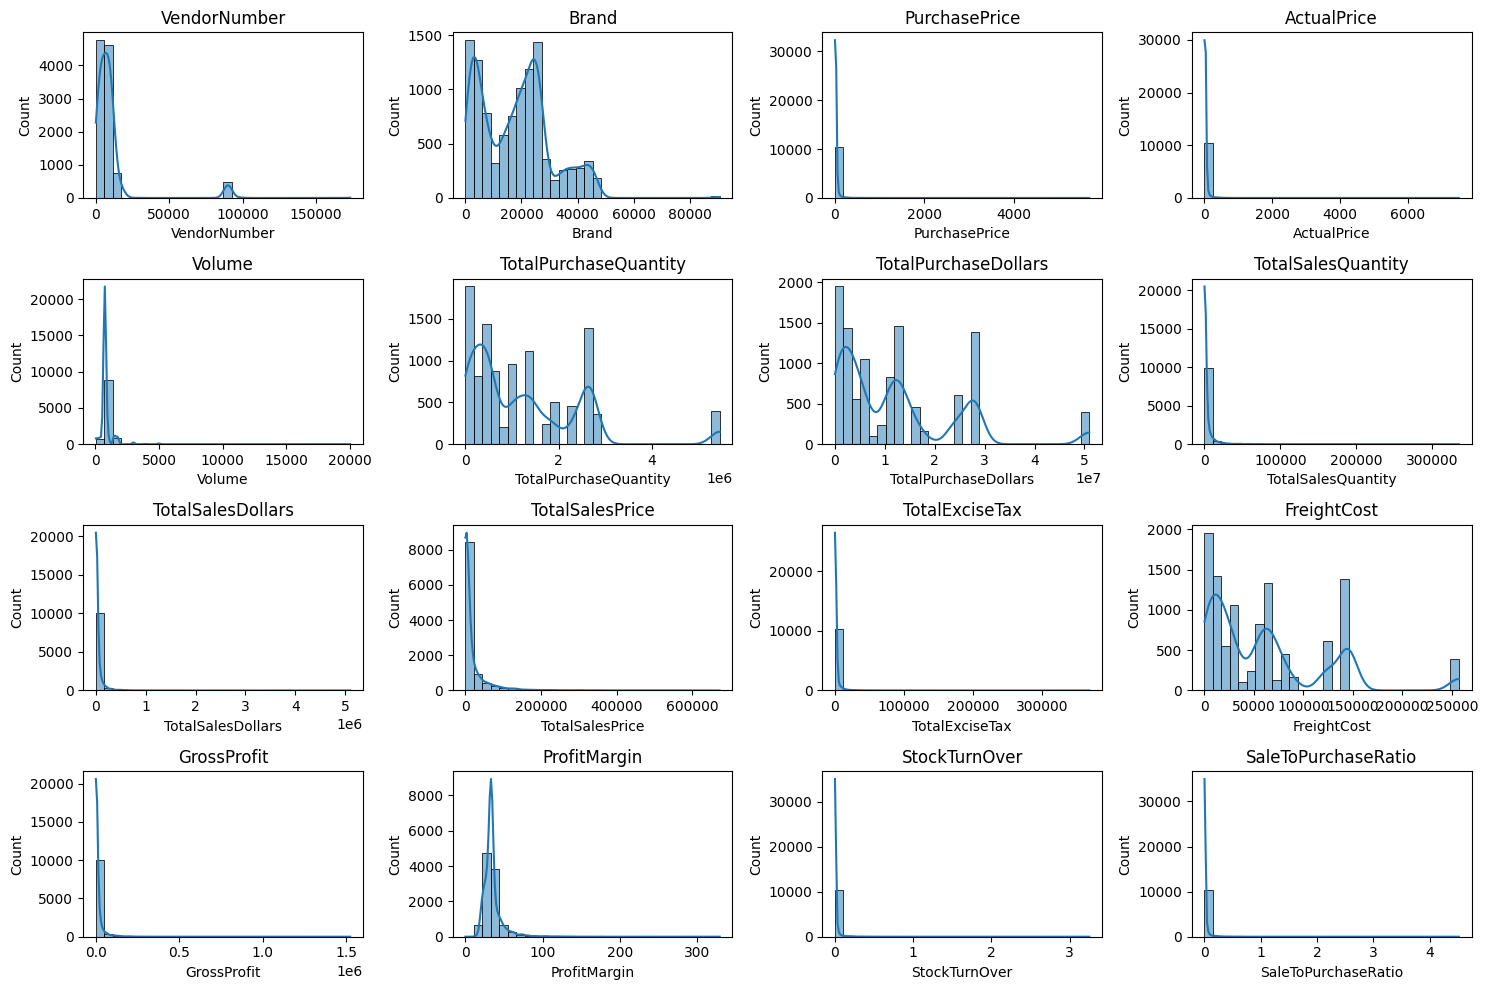

In [ ]:
numerical_cols=df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
  plt.subplot(4,4,i+1)
  sns.histplot(df[col],kde=True,bins=30)
  plt.title(col)
plt.tight_layout()
plt.show()

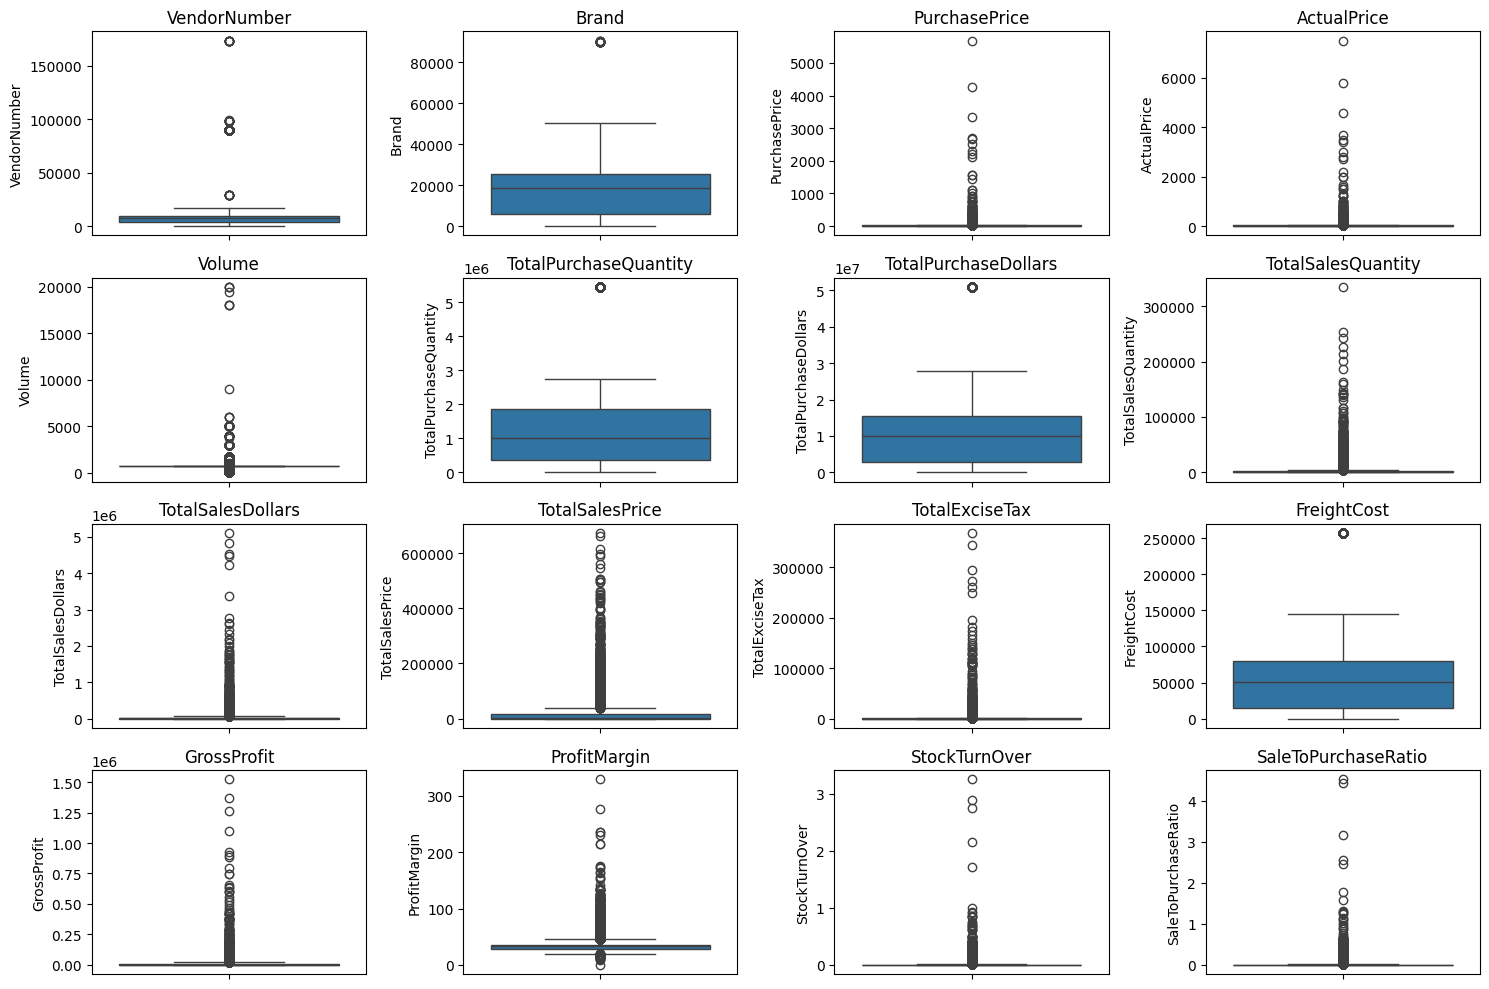

In [ ]:
#Outlier Detection with Boxplots
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
  plt.subplot(4,4,i+1)
  sns.boxplot(df[col])
  plt.title(col)
plt.tight_layout()
plt.show()

In [ ]:
#removing inconsistencies
df=pd.read_sql_query("""SELECT * FROM vendor_sales_summary
WHERE GrossProfit>0
AND ProfitMargin>0
AND TotalSalesQuantity>0""",conn)

In [ ]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnOver,SaleToPurchaseRatio
0,8320,SHAW ROSS INT L IMP LTD,58,Gekkeikan Black & Gold Sake,9.28,12.99,750.0,69127.0,624979.64,3446.0,43341.54,28145.64,2715.12,3151.92,12784.66,29.497475,0.049850,0.069349
1,1128,BROWN-FORMAN CORP,62,Herradura Silver Tequila,28.67,36.99,750.0,1006122.0,13529433.08,3125.0,119863.75,90154.51,2463.18,68601.68,26000.00,21.691295,0.003106,0.008859
2,1128,BROWN-FORMAN CORP,63,Herradura Reposado Tequila,30.46,38.99,750.0,1006122.0,13529433.08,2778.0,112249.22,88553.10,2190.45,68601.68,23696.34,21.110472,0.002761,0.008297
3,9165,ULTRA BEVERAGE COMPANY LLP,72,No. 3 London Dry Gin,26.11,34.99,750.0,1077527.0,13210613.93,469.0,17325.31,12626.57,369.84,68054.70,4164.72,24.038358,0.000435,0.001311
4,7245,PROXIMO SPIRITS INC.,75,Three Olives Tomato Vodka,10.94,14.99,750.0,682042.0,7588029.90,21.0,314.79,134.91,16.53,38994.78,85.05,27.018012,0.000031,0.000041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10465,90024,VINILANDIA USA,44917,Ferreira 10-Yr Tawny Port,16.55,24.99,750.0,59428.0,548855.37,1.0,24.99,24.99,0.11,2802.64,8.44,33.773509,0.000017,0.000046
10466,4425,MARTIGNETTI COMPANIES,44944,Sanford Santa Rita Pnt Nr,14.93,22.99,750.0,2640411.0,27861690.02,1133.0,26047.67,11747.89,126.38,144929.24,9131.98,35.058721,0.000429,0.000935
10467,10754,PERFECTA WINES,45016,Neal One Lane Bridg Cab Svgn,61.43,93.99,750.0,553116.0,5665501.53,2.0,187.98,187.98,0.22,28720.52,65.12,34.641983,0.000004,0.000033
10468,9744,FREDERICK WILDMAN & SONS,46011,Folonari Pnt Nr Venezie,8.90,12.99,1500.0,70932.0,759449.24,4.0,51.96,25.98,0.90,3999.93,16.36,31.485758,0.000056,0.000068


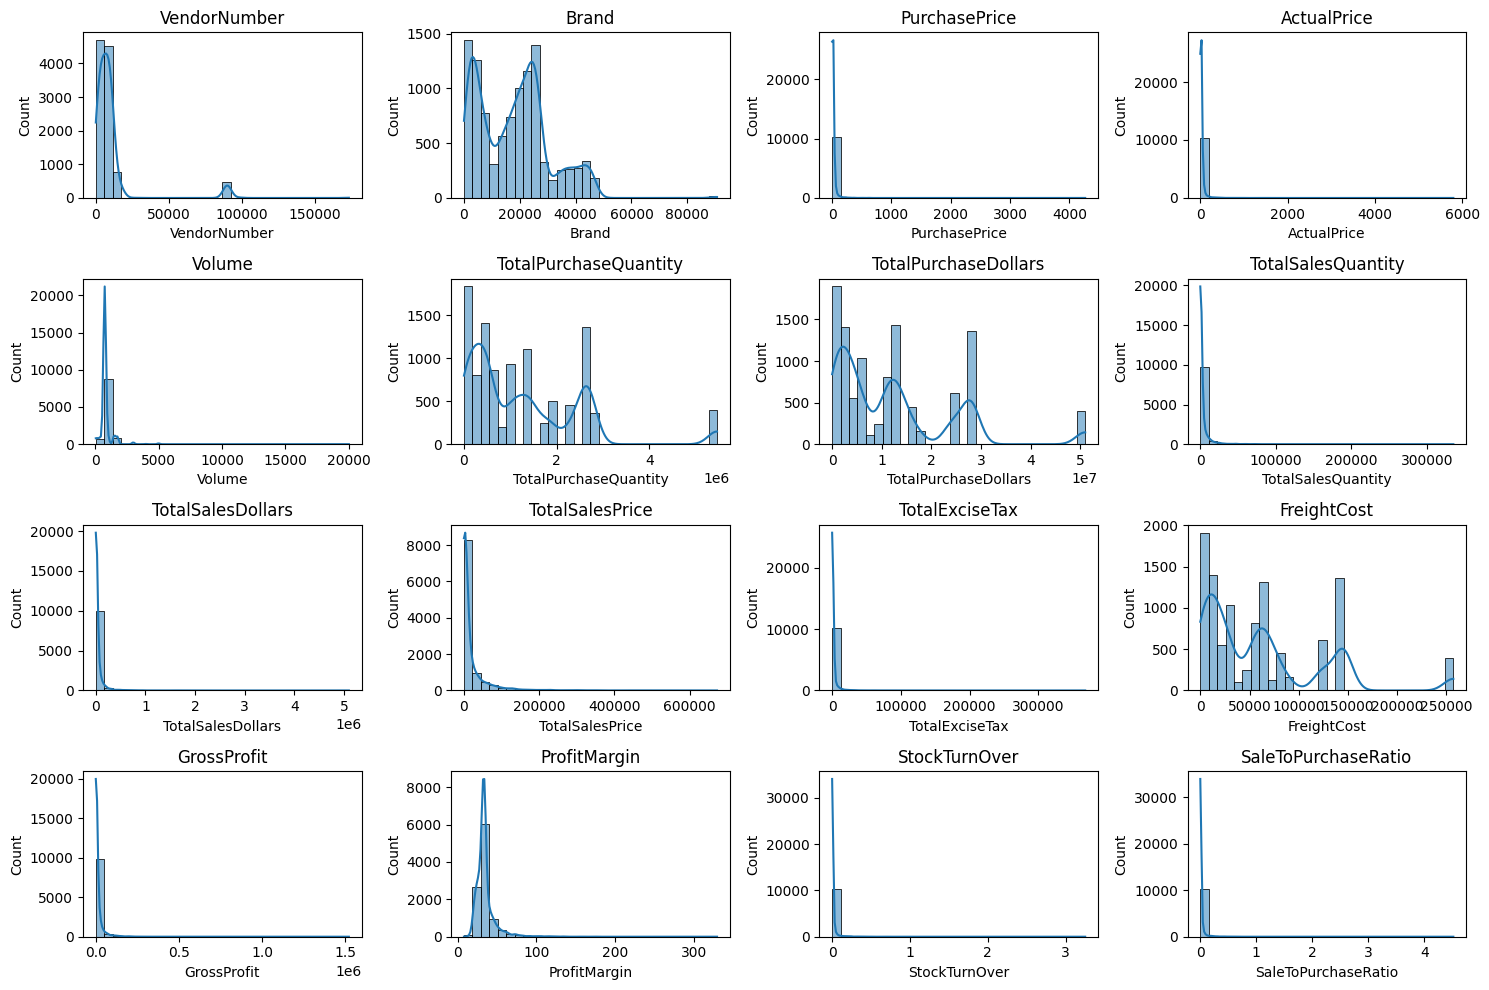

In [ ]:
numerical_cols=df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
  plt.subplot(4,4,i+1)
  sns.histplot(df[col],kde=True,bins=30)
  plt.title(col)
plt.tight_layout()
plt.show()

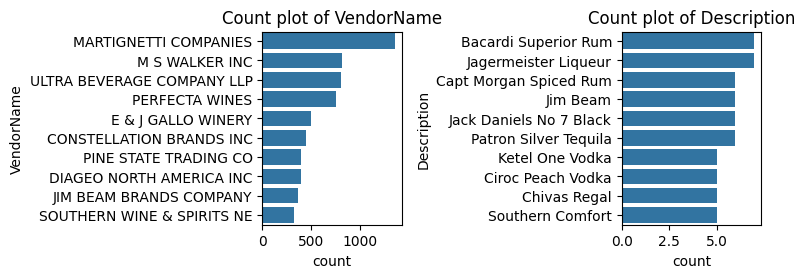

In [ ]:
#Count Plot
categorical_cols=["VendorName","Description"]
plt.figure(figsize=(15,10))
for i,col in enumerate(categorical_cols):
  plt.subplot(4,4,i+1)
  sns.countplot(y=df[col], order=df[col].value_counts().index[:10])
  plt.title(f"Count plot of {col}")
plt.tight_layout()
plt.show()

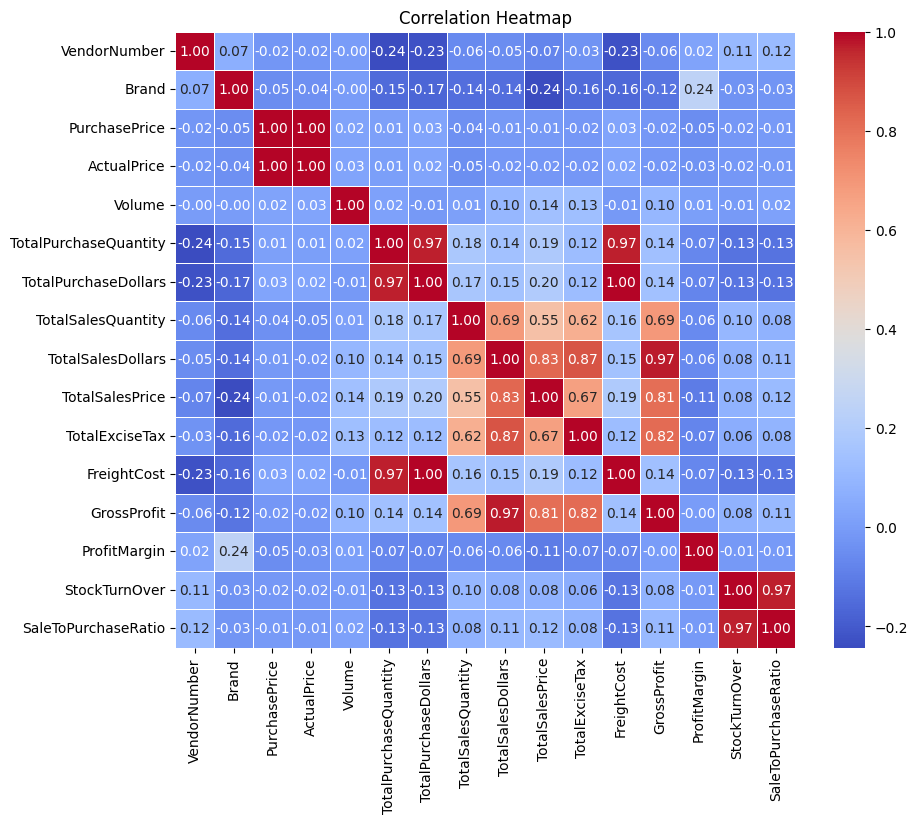

In [ ]:
#Correlation Heatmap
plt.figure(figsize=(10,8))
correlation_matrix=df[numerical_cols].corr()
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

**Identify brands that needs promotional or pricing adjustments which exhibit lower sales performance but higher profit margins**

In [ ]:
brand_performance=df.groupby('Description').agg({
    'TotalSalesDollars': 'sum',
    'ProfitMargin': 'mean'
}).reset_index()

In [ ]:
low_sales_threshold=brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold=brand_performance['ProfitMargin'].quantile(0.85)

In [ ]:
print(low_sales_threshold)

341.925


In [ ]:
print(high_margin_threshold)

41.39423354806447


We have to target brands which is higher than 41.4 and less than 342 for promotional purpose.

In [ ]:
#Filter brands with low sales but high profit margins
target_brands=brand_performance[
    (brand_performance['TotalSalesDollars']<=low_sales_threshold) &
    (brand_performance['ProfitMargin']>=high_margin_threshold)
]
print("**Brands with low sales but high profit margins**")
display(target_brands.sort_values('TotalSalesDollars'))

**Brands with low sales but high profit margins**


,Description,TotalSalesDollars,ProfitMargin
753,Belcreme de Lys Pnt Nr,9.99,46.146146
2845,Debauchery Pnt Nr,11.58,173.575130
2494,Concannon Glen Ellen Wh Zin,15.95,115.047022
5642,Maggio Petite Sirah,26.97,42.380423
7009,Prichard's Single Malt,34.99,66.533295
...,...,...,...
9099,Vin Vault Pnt Nr,314.70,115.633937
8852,Triibe Celtic,318.83,45.855158
1185,Broadside Cab Svgn Paso Rob,326.94,64.654065
8474,Tenuta Santo Pietro Imago 11,329.25,45.785877


**Scatter Plot**

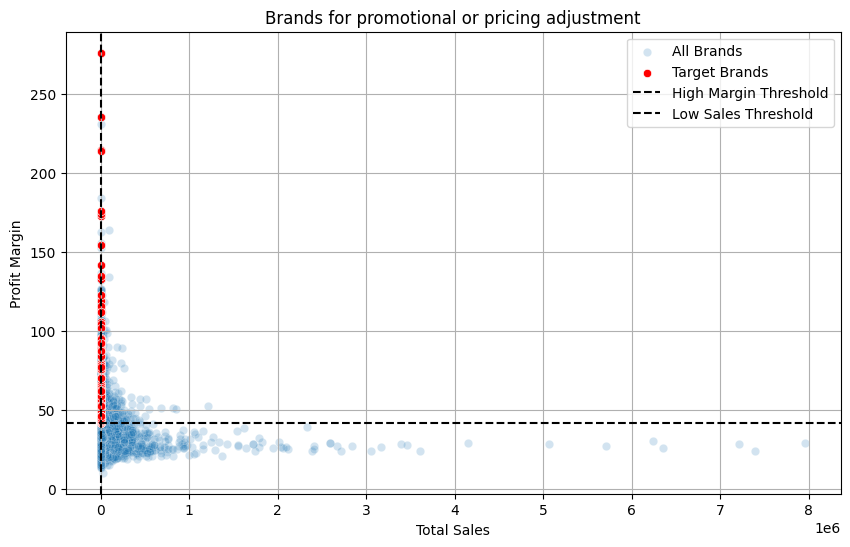

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=brand_performance,x='TotalSalesDollars',y='ProfitMargin',label='All Brands',alpha=0.2)
sns.scatterplot(data=target_brands,x='TotalSalesDollars',y='ProfitMargin',label='Target Brands',color='red')

plt.axhline(high_margin_threshold,color='black',linestyle='--',label='High Margin Threshold')
plt.axvline(low_sales_threshold,color='black',linestyle='--',label='Low Sales Threshold')

plt.title("Brands for promotional or pricing adjustment")
plt.xlabel("Total Sales")
plt.ylabel("Profit Margin")
plt.grid(True)
plt.legend()
plt.show()

Which vendors and brands demonstrate the highest sales performance?

In [ ]:
#Converts lakh and millions to K and M format.
def format_dollar(num):
    if abs(num) >= 1_000_000:
        return f'{num / 1_000_000:.1f}M'
    elif abs(num) >= 1_000:
        return f'{num / 1_000:.1f}K'
    else:
        return f'{num:.2f}'

In [ ]:
top_vendors = df.groupby('VendorName')['TotalSalesDollars'].sum().nlargest(10)
top_brands = df.groupby('Description')['TotalSalesDollars'].sum().nlargest(10)

In [ ]:
top_vendors.apply(lambda x: format_dollar(x))

,TotalSalesDollars
VendorName,
DIAGEO NORTH AMERICA INC,68.7M
MARTIGNETTI COMPANIES,41.0M
PERNOD RICARD USA,32.3M
JIM BEAM BRANDS COMPANY,31.9M
BACARDI USA INC,25.0M
CONSTELLATION BRANDS INC,24.5M
E & J GALLO WINERY,18.6M
BROWN-FORMAN CORP,18.5M
ULTRA BEVERAGE COMPANY LLP,17.7M


In [ ]:
top_brands.apply(lambda x: format_dollar(x))

,TotalSalesDollars
Description,
Jack Daniels No 7 Black,8.0M
Tito's Handmade Vodka,7.4M
Grey Goose Vodka,7.2M
Capt Morgan Spiced Rum,6.4M
Absolut 80 Proof,6.2M
Jameson Irish Whiskey,5.7M
Ketel One Vodka,5.1M
Baileys Irish Cream,4.2M
Kahlua,3.6M


**Plots for top vendors and top brands**

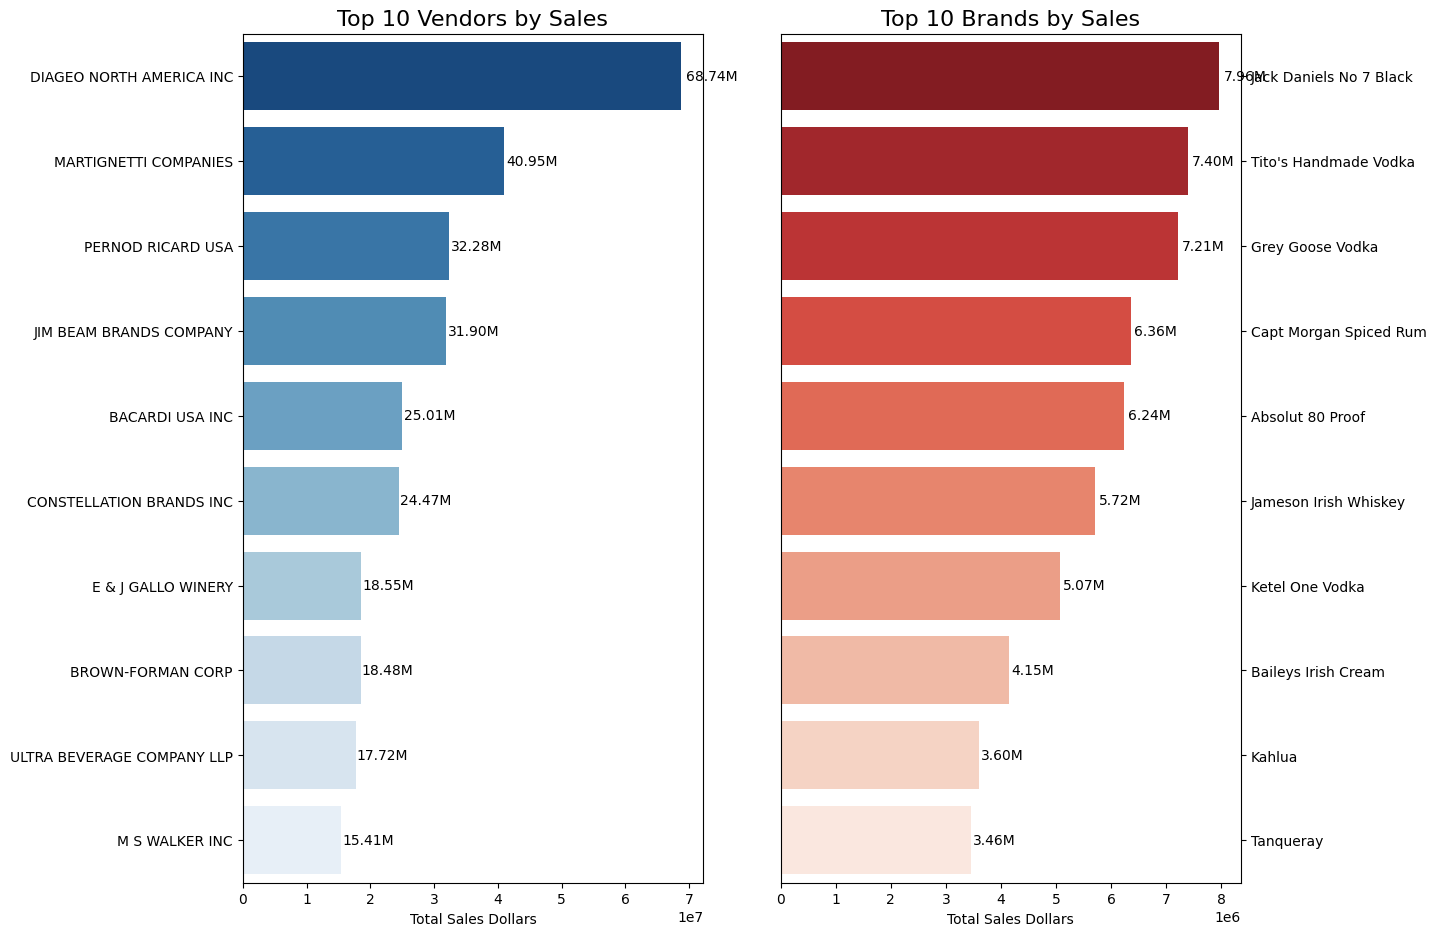

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

# Plot 1: Top 10 Vendors
vendor_plot = sns.barplot(x=top_vendors.values, y=top_vendors.index, ax=ax1, palette='Blues_r', orient='h')
ax1.set_title('Top 10 Vendors by Sales', fontsize=16)
ax1.set_xlabel('Total Sales Dollars')
ax1.set_ylabel('')

# Add data labels to the vendor bars
for p in vendor_plot.patches:
    width = p.get_width()
    ax1.text(width * 1.01,
             p.get_y() + p.get_height() / 2,
             f'{width / 1e6:.2f}M',
             va='center')

# Plot 2: Top 10 Brands
brand_plot = sns.barplot(x=top_brands.values, y=top_brands.index, ax=ax2, palette='Reds_r', orient='h')
ax2.set_title('Top 10 Brands by Sales', fontsize=16)
ax2.set_xlabel('Total Sales Dollars')
ax2.set_ylabel('')
ax2.yaxis.tick_right()

# Add data labels to the brand bars
for p in brand_plot.patches:
    width = p.get_width()
    ax2.text(width * 1.01,
             p.get_y() + p.get_height() / 2,
             f'{width / 1e6:.2f}M',
             va='center')

plt.tight_layout(pad=3.0)
plt.show()

**Which vendors contribute the most to Total Purchase Dollars?**

In [ ]:
vendor_performance = df.groupby('VendorName').agg({
    'TotalPurchaseDollars': 'sum',
    'GrossProfit': 'sum',
    'TotalSalesDollars': 'sum'
})

In [ ]:
vendor_performance['PurchaseContribution%'] = vendor_performance['TotalPurchaseDollars'] / vendor_performance['TotalPurchaseDollars'].sum()*100

In [ ]:
vendor_performance=round(vendor_performance.sort_values('PurchaseContribution%', ascending=False),2)

In [ ]:
#Display top 10 vendors
top_vendors = vendor_performance.head(10).reset_index()
top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(lambda x: format_dollar(x))
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(lambda x: format_dollar(x))
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(lambda x: format_dollar(x))
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%
0,MARTIGNETTI COMPANIES,37891.9M,14.1M,41.0M,30.021302
1,DIAGEO NORTH AMERICA INC,20129.1M,19.1M,68.7M,15.948063
2,ULTRA BEVERAGE COMPANY LLP,10661.0M,6.2M,17.7M,8.446557
3,M S WALKER INC,8890.8M,5.4M,15.4M,7.044091
4,JIM BEAM BRANDS COMPANY,8882.6M,8.9M,31.9M,7.037544
5,CONSTELLATION BRANDS INC,7055.0M,9.3M,24.5M,5.589581
6,E & J GALLO WINERY,6144.8M,7.0M,18.6M,4.868455
7,PERNOD RICARD USA,5910.4M,8.7M,32.3M,4.682742
8,PERFECTA WINES,4305.8M,3.0M,7.7M,3.411419
9,BACARDI USA INC,2890.4M,7.2M,25.0M,2.290028


In [ ]:
top_vendors['CumulativeContribution%'] = vendor_performance['PurchaseContribution%'].cumsum()
top_vendors

,ProfitMargin
0,29.497475
1,21.691295
2,21.110472
5,18.906723
6,38.688045
...,...
10105,23.158107
10307,31.971018
10324,31.947652
10458,30.628127


In [ ]:
vendor_performance.columns

Index(['TotalPurchaseDollars', 'GrossProfit', 'TotalSalesDollars',
       'PurchaseContribution%'],
      dtype='object')

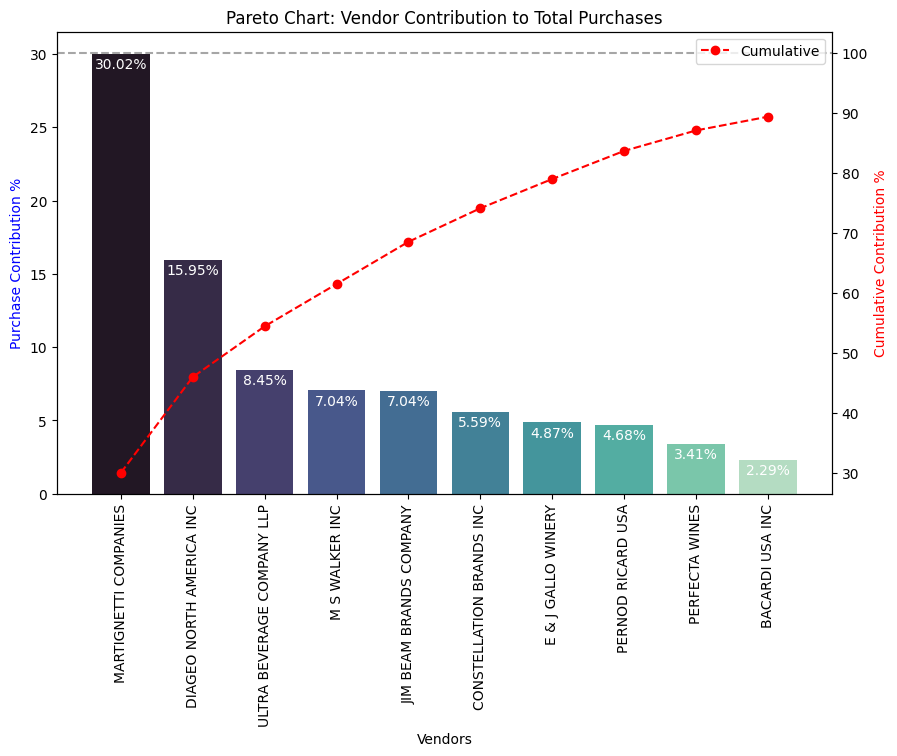

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Purchase Contribution%
sns.barplot(x=top_vendors['VendorName'], y=top_vendors['PurchaseContribution%'], palette='mako', ax=ax1)
for i, value in enumerate(top_vendors['PurchaseContribution%']):
    # This line is changed to format the value to 2 decimal places
    ax1.text(i, value - 1, f'{value:.2f}%', ha='center', fontsize=10, color='white')

# Line Plot for Cumulative Contribution%
ax2 = ax1.twinx()
ax2.plot(top_vendors['VendorName'], top_vendors['CumulativeContribution%'], color='red', marker='o', linestyle='dashed', label='Cumulative')

ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)
ax1.set_ylabel('Purchase Contribution %', color='blue')
ax2.set_ylabel('Cumulative Contribution %', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')

ax2.axhline(y=100, color='gray', linestyle='dashed', alpha=0.7)
ax2.legend(loc='upper right')

plt.show()

**How much of total procurement is dependent on top vendors?**

In [ ]:
print(f"Total Purchase Contribution of top 10 vendors is {round(top_vendors['PurchaseContribution%'].sum(),2)}%")

Total Purchase Contribution of top 10 vendors is 89.34%


,ProfitMargin
0,29.497475
1,21.691295
2,21.110472
5,18.906723
6,38.688045
...,...
10104,25.362681
10105,23.158107
10307,31.971018
10324,31.947652


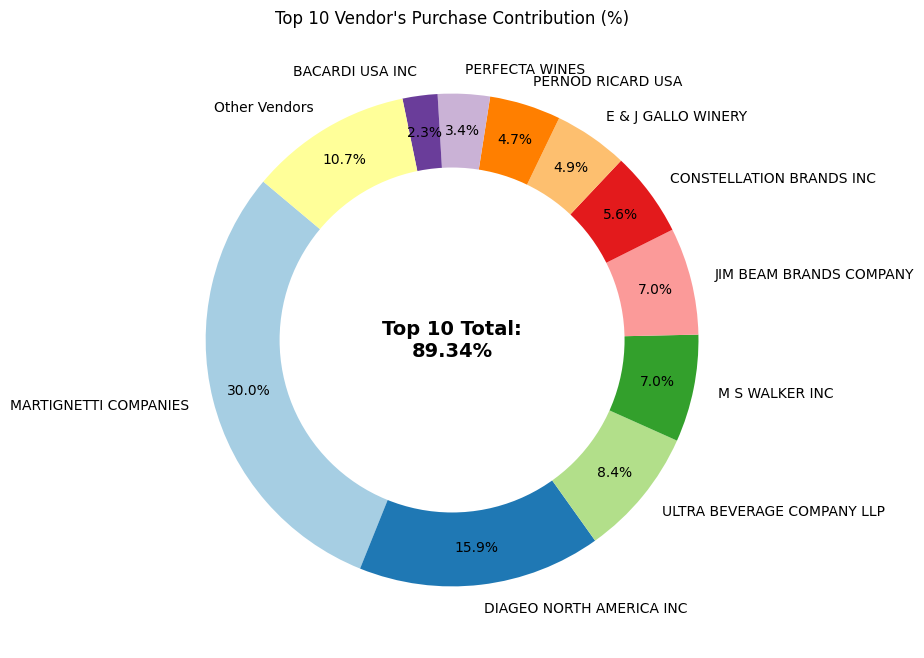

In [ ]:
vendors = list(top_vendors['VendorName'].values)
purchase_contributions = list(top_vendors['PurchaseContribution%'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors" category
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(purchase_contributions, labels=vendors, autopct='%1.1f%%',
                                  startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

# Draw a white circle in the center to create a "donut" effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add Total Contribution annotation in the center
plt.text(0, 0, f"Top 10 Total:\n{total_contribution:.2f}%", fontsize=14, fontweight='bold', ha='center', va='center')

plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.show()

**Does purchasing in bulk reduce the unit price and what is the optimal purchase volume for cost saving?**

In [ ]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars'] / df['TotalPurchaseQuantity']

In [ ]:
df['OrderSize'] = pd.qcut(df['TotalPurchaseQuantity'], q=3, labels=['Small', 'Medium', 'Large'])

In [ ]:
df[['OrderSize','TotalPurchaseQuantity']]

,OrderSize,TotalPurchaseQuantity
0,Small,69127.0
1,Medium,1006122.0
2,Medium,1006122.0
3,Medium,1077527.0
4,Medium,682042.0
...,...,...
10465,Small,59428.0
10466,Large,2640411.0
10467,Medium,553116.0
10468,Small,70932.0


In [ ]:
df.groupby('OrderSize')['UnitPurchasePrice'].mean()

,UnitPurchasePrice
OrderSize,
Small,10.346124
Medium,10.086881
Large,9.539461


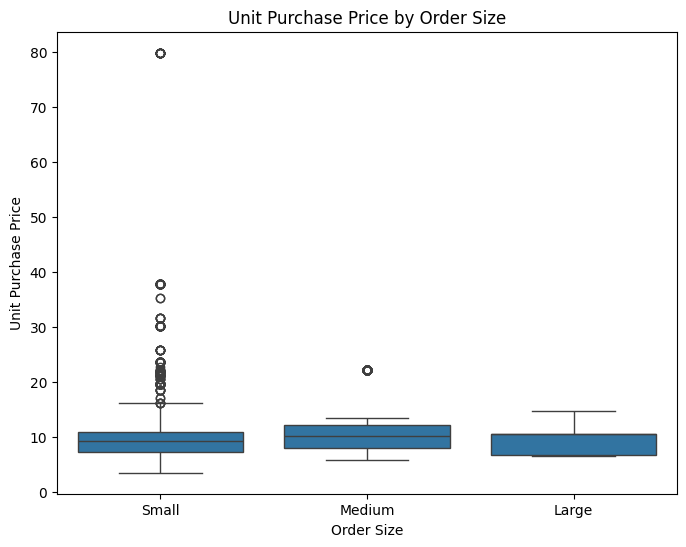

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='OrderSize', y='UnitPurchasePrice', data=df, order=['Small', 'Medium', 'Large'])
plt.title("Unit Purchase Price by Order Size")
plt.xlabel("Order Size")
plt.ylabel("Unit Purchase Price")
plt.show()

**This states the higher the order size lesser the Unit Purchase Price. Thus, bulk pricing stratergies encourage vendors to purchase items in large volumes.**

**Which vendors have low inventory turnover, indicating excess stock and slow-moving products?**

In [ ]:
df[df['StockTurnOver'] < 1].groupby('VendorName')['StockTurnOver'].mean().sort_values(ascending=True).head(10)

,StockTurnOver
VendorName,
VINEYARD BRANDS LLC,0.000201
MARTIGNETTI COMPANIES,0.000718
SOUTHERN GLAZERS W&S OF NE,0.000898
PERFECTA WINES,0.001195
ULTRA BEVERAGE COMPANY LLP,0.001196
M S WALKER INC,0.001201
E & J GALLO WINERY,0.001947
CONSTELLATION BRANDS INC,0.002184
PINE STATE TRADING CO,0.002459


**What is the 95% confidence intervals for profit margins of top-performing and low-performing vendors?**

In [ ]:
top_threshold=df['TotalSalesDollars'].quantile(0.75)
low_threshold=df['TotalSalesDollars'].quantile(0.25)

In [ ]:
top_vendors = df[df['TotalSalesDollars'] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df['TotalSalesDollars'] <= low_threshold]["ProfitMargin"].dropna()

In [ ]:
top_vendors

,ProfitMargin
0,29.497475
1,21.691295
2,21.110472
5,18.906723
6,38.688045
...,...
10104,25.362681
10105,23.158107
10307,31.971018
10324,31.947652


In [ ]:
low_vendors

,ProfitMargin
4,27.018012
132,22.471660
138,17.745163
175,26.237371
247,58.263319
...,...
10463,33.772045
10465,33.773509
10467,34.641983
10468,31.485758
